# <center> Models Analysis </center>

## <center>Baseline</center>


|                     | Random Forest |          LightGBM |            XGBoost |          CatBoost |
|--------------------:|--------------:|------------------:|-------------------:|------------------:|
|            Accuracy |        0.7364 |            0.7395 |         **0.7397** |            0.7392 |
|             ROC AUC |      0.615017 |          0.630551 |       **0.639458** |          0.616246 |
|       Training Time | 0 min 37 secs | 2 mins and 45 secs | 8 mins and 58 secs | **0 min 21 secs** |
| Inference time Unit | 0.927343 secs | **0.004546 secs** |      0.019042 secs |     0.549788 secs |
|                Size |      190.11MB |            0.72MB |             0.79MB |         **0.2MB** |

## Model podium performance



|                     | AUC | Inference time |
|---------------------|-----|----------------|
| XGBoost             | 🥇   | 🥉           |
| CatBoost            | 🥉   | 🥈           |
| LightGBM            | 🥈   | 🥇           |

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from src import utils
from src.models import predict_model
import os
import warnings
warnings.filterwarnings("ignore")

### Load pre-processed data

In [ ]:
X_train = utils.load_data_checkpoint('../data/processed/X_train.pickle')
X_test = utils.load_data_checkpoint('../data/processed/X_test.pickle')
y_train = utils.load_data_checkpoint('../data/processed/y_train.pickle')
y_test = utils.load_data_checkpoint('../data/processed/y_test.pickle')

In [5]:
print(f"X_train = {X_train.shape}, X_test = {X_test.shape}")
print(f"y_train = {y_train.shape}, y_test = {y_test.shape}")

X_train = (40000, 1773), X_test = (10000, 1773)
y_train = (40000,), y_test = (10000,)


-----------------------------------------------
### 1.0 - Training a Random Forest Classifier 
-----------------------------------------------

In [6]:
#instance object
rforest = RandomForestClassifier(n_jobs=-1, random_state=42)

#setting timer to now
start_time = utils.timer(None)

#train and predict 
rforest.fit(X_train, y_train)

#use function time based on setting before
utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 37.731468 secs


#### 1.1 - Random Forest Classifier: Inference time

In [7]:
start_time = utils.timer(None)

y_pred = rforest.predict(X_test.iloc[0].values.reshape(1,-1))

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.099434 secs


/home/app/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### 1.2 - Random Forest Classifier: Performance metrics and classification report

In [8]:
start_time = utils.timer(None)

y_pred = rforest.predict(X_test)

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.927343 secs


Model Performance metrics:
------------------------------
Accuracy: 0.7364
Precision: 0.4320388349514563
Recall: 0.03412576687116564
F1 Score: 0.06325515280739161

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      0.98      0.85      7392
           1       0.43      0.03      0.06      2608

    accuracy                           0.74     10000
   macro avg       0.59      0.51      0.45     10000
weighted avg       0.66      0.74      0.64     10000


Prediction Confusion Matrix:
------------------------------
      0    1
0  7275  117
1  2519   89


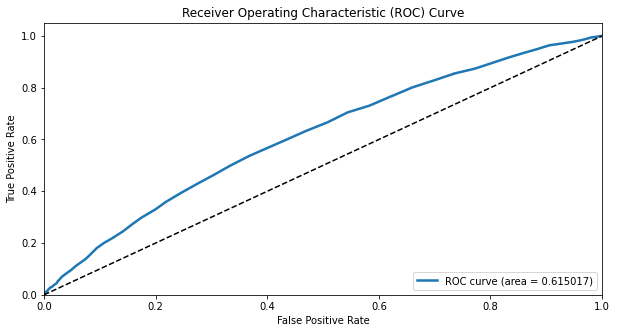

In [9]:
accuracy, precision, recall, f1_score = predict_model.get_performance(y_pred,y_test,labels=[0,1])
roc_auc = predict_model.plot_roc(rforest,y_test,X_test)

#### 1.3 -  Random Forest Classifier: Save model


In [62]:
utils.save_data_checkpoint(rforest,'../src/models/trained_models/simplerforest.pickle')

Object saved successfully in ../src/models/trained_models/simplerforest.pickle with 190.11MB.


-----------------------------------------------
### 2.0 - Training a LightGBM Classifier 
-----------------------------------------------

In [15]:
lgbclf = lgb.LGBMClassifier(random_state=42)

#setting timer
start_time = utils.timer(None)

param_grid = {
    'boosting_type': ['gbdt'],
    'importance_type':['split'],
    'learning_rate':[0.1,0.01,0.001],
    'max_depth':[-1,1,2],
    'n_estimators':[100,200,300],
    'num_leaves':[30,15,5]
}

lgbclf_randomcv = RandomizedSearchCV(lgbclf, param_grid, n_iter=1, random_state=42, cv=4,scoring='roc_auc',verbose=8)

lgbclf_randomcv.fit(X_train, y_train)

#use function time based on setting before
utils.timer(start_time)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END boosting_type=gbdt, importance_type=split, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=30;, score=0.630 total time=  42.0s
[CV 2/4] END boosting_type=gbdt, importance_type=split, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=30;, score=0.634 total time=  35.6s
[CV 3/4] END boosting_type=gbdt, importance_type=split, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=30;, score=0.625 total time=  28.3s
[CV 4/4] END boosting_type=gbdt, importance_type=split, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=30;, score=0.632 total time=  35.9s
Time taken by function: 0 hours , 2 mins and 45.803425000000004 secs


#### 2.1 LightGBM Classifier: Best hyperparameters with RandomizedsearchCV

In [16]:
print(f'LightGBM Classifier:\n\nBest params:')
for key, values in lgbclf_randomcv.best_params_.items():
  print(f'{key} : {values}')
print(f"\nBest Score: {lgbclf_randomcv.best_score_:.6f}\n")

LightGBM Classifier:

Best params:
num_leaves : 30
n_estimators : 200
max_depth : -1
learning_rate : 0.01
importance_type : split
boosting_type : gbdt

Best Score: 0.630276



#### 2.2 LightGBM Classifier: Inference time

In [17]:
start_time = utils.timer(None)

y_pred = lgbclf_randomcv.predict(X_test.iloc[0].values.reshape(1,-1))

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.004546 secs


#### 2.3 - LightGBM Classifier: Performance metrics and classification report

In [18]:
start_time = utils.timer(None)

y_pred = lgbclf_randomcv.predict(X_test)

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.529568 secs


Model Performance metrics:
------------------------------
Accuracy: 0.7395
Precision: 1.0
Recall: 0.0011503067484662577
F1 Score: 0.002297970126388357

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7392
           1       1.00      0.00      0.00      2608

    accuracy                           0.74     10000
   macro avg       0.87      0.50      0.43     10000
weighted avg       0.81      0.74      0.63     10000


Prediction Confusion Matrix:
------------------------------
      0  1
0  7392  0
1  2605  3


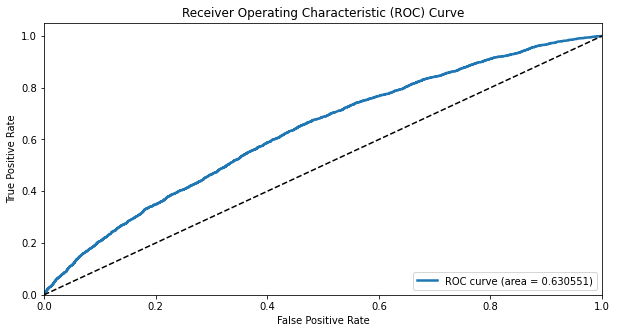

In [19]:
accuracy, precision, recall, f1_score = predict_model.get_performance(y_pred,y_test,labels=[0,1])
roc_auc = predict_model.plot_roc(lgbclf_randomcv,y_test,X_test)

#### 2.4 - LightGBM Classifier: Save model


In [45]:
utils.save_data_checkpoint(lgbclf_randomcv,'../src/models/trained_models/lgbm.pickle')

Object saved successfully in ../src/models/trained_models/lgbm.pickle with 0.72MB.


-----------------------------------------------
### 3.0 - Training a XGBClassifier
-----------------------------------------------

In [20]:
xgb_cl = xgb.XGBClassifier(random_state=42)

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

start_time = utils.timer(None)

xgb_cl_randomcv = RandomizedSearchCV(xgb_cl, param_grid, n_iter=1, random_state=42, cv=4,scoring='roc_auc',verbose=8)

xgb_cl_randomcv.fit(X_train, y_train)

utils.timer(start_time)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.640 total time= 1.7min
[CV 2/4] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.640 total time= 1.8min
[CV 3/4] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.634 total time= 1.6min
[CV 4/4] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.643 total time= 1.7min
Time taken by function: 0 hours , 8 mins and 57.90629799999999 secs


#### 3.1 - XGBoost Classifier: Best hyperparameters with RandomizedsearchCV 

In [21]:
print(f'XGBoost Classifier:\n\nBest params:')
for key, values in xgb_cl_randomcv.best_params_.items():
  print(f'{key} : {values}')
print(f"\nBest Score: {xgb_cl_randomcv.best_score_:.6f}\n")

XGBoost Classifier:

Best params:
subsample : 0.8
scale_pos_weight : 1
reg_lambda : 1
max_depth : 7
learning_rate : 0.05
gamma : 0
colsample_bytree : 0.5

Best Score: 0.639478



#### 3.2 - XGBoost Classifier: Inference time

In [22]:
start_time = utils.timer(None)

y_pred = xgb_cl_randomcv.predict(X_test.iloc[0].values.reshape(1,-1))

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.019042 secs


#### 3.3 - XGBoost Classifier: Performance metrics and classification report

In [23]:
start_time = utils.timer(None)

y_pred = xgb_cl_randomcv.predict(X_test)

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.624998 secs


Model Performance metrics:
------------------------------
Accuracy: 0.7397
Precision: 0.5714285714285714
Recall: 0.007668711656441718
F1 Score: 0.015134317063942491

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7392
           1       0.57      0.01      0.02      2608

    accuracy                           0.74     10000
   macro avg       0.66      0.50      0.43     10000
weighted avg       0.70      0.74      0.63     10000


Prediction Confusion Matrix:
------------------------------
      0   1
0  7377  15
1  2588  20


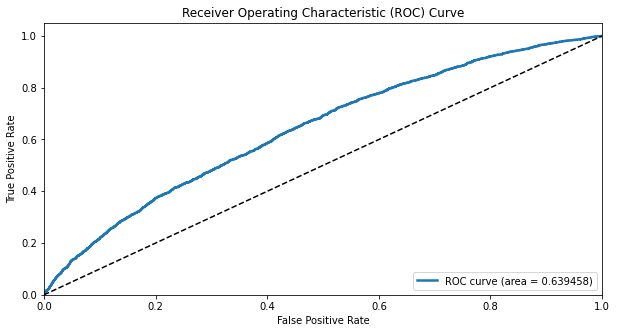

In [24]:
accuracy, precision, recall, f1_score = predict_model.get_performance(y_pred,y_test,labels=[0,1])
roc_auc = predict_model.plot_roc(xgb_cl_randomcv,y_test,X_test)

#### 3.4 - XGBoost Classifier: Save model


In [50]:
utils.save_data_checkpoint(xgb_cl_randomcv,'../src/models/trained_models/xgb.pickle')

Object saved successfully in ../src/models/trained_models/xgb.pickle with 0.79MB.


-----------------------------------------------
### 4.0 - Training a CatBoost Classifier
-----------------------------------------------

In [25]:
cbc = CatBoostClassifier(random_state=42)

parameters = {
    'depth': [4,5,6,7,8,9, 10],
    'learning_rate': [0.01,0.02,0.03,0.04],
    'iterations': [10, 20,30,40,50,60,70,80,90,100]
}

start_time = utils.timer(None)

cbc_randomcv = RandomizedSearchCV(cbc, parameters, n_iter=1, random_state=42, cv=4,scoring='roc_auc',verbose=8)
cbc_randomcv.fit(X_train, y_train)

utils.timer(start_time)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
0:	learn: 0.6855778	total: 87.5ms	remaining: 5.16s
1:	learn: 0.6776493	total: 116ms	remaining: 3.38s
2:	learn: 0.6703309	total: 149ms	remaining: 2.82s
3:	learn: 0.6641159	total: 170ms	remaining: 2.38s
4:	learn: 0.6578423	total: 197ms	remaining: 2.17s
5:	learn: 0.6519605	total: 227ms	remaining: 2.04s
6:	learn: 0.6461849	total: 258ms	remaining: 1.96s
7:	learn: 0.6411062	total: 292ms	remaining: 1.9s
8:	learn: 0.6362078	total: 319ms	remaining: 1.81s
9:	learn: 0.6318418	total: 345ms	remaining: 1.73s
10:	learn: 0.6277728	total: 378ms	remaining: 1.68s
11:	learn: 0.6239287	total: 404ms	remaining: 1.62s
12:	learn: 0.6201049	total: 436ms	remaining: 1.58s
13:	learn: 0.6166900	total: 463ms	remaining: 1.52s
14:	learn: 0.6136231	total: 494ms	remaining: 1.48s
15:	learn: 0.6105626	total: 522ms	remaining: 1.44s
16:	learn: 0.6076590	total: 567ms	remaining: 1.44s
17:	learn: 0.6050566	total: 611ms	remaining: 1.43s
18:	learn: 0.6022444	total: 641ms

38:	learn: 0.5721734	total: 817ms	remaining: 440ms
39:	learn: 0.5715004	total: 836ms	remaining: 418ms
40:	learn: 0.5708791	total: 851ms	remaining: 394ms
41:	learn: 0.5703126	total: 870ms	remaining: 373ms
42:	learn: 0.5697782	total: 890ms	remaining: 352ms
43:	learn: 0.5691272	total: 912ms	remaining: 331ms
44:	learn: 0.5683842	total: 930ms	remaining: 310ms
45:	learn: 0.5677492	total: 955ms	remaining: 291ms
46:	learn: 0.5670799	total: 974ms	remaining: 269ms
47:	learn: 0.5665253	total: 994ms	remaining: 248ms
48:	learn: 0.5659890	total: 1.02s	remaining: 229ms
49:	learn: 0.5654723	total: 1.04s	remaining: 208ms
50:	learn: 0.5649805	total: 1.06s	remaining: 187ms
51:	learn: 0.5645579	total: 1.08s	remaining: 166ms
52:	learn: 0.5639644	total: 1.1s	remaining: 146ms
53:	learn: 0.5635364	total: 1.13s	remaining: 126ms
54:	learn: 0.5631308	total: 1.15s	remaining: 105ms
55:	learn: 0.5627669	total: 1.17s	remaining: 83.7ms
56:	learn: 0.5624429	total: 1.19s	remaining: 62.8ms
57:	learn: 0.5619809	total: 1.

#### 4.1 - Catboost  Classifier: Best hyperparameters with RandomizedsearchCV 

In [26]:
print(f'CatBoost Classifier:\n\nBest params:')
for key, values in cbc_randomcv.best_params_.items():
  print(f'{key} : {values}')
print(f"\nBest Score: {cbc_randomcv.best_score_:.6f}\n")

CatBoost Classifier:

Best params:
learning_rate : 0.03
iterations : 60
depth : 6

Best Score: 0.616874



#### 4.2 - CatBoost Classifier: Inference time

In [27]:
start_time = utils.timer(None)

y_pred = cbc_randomcv.predict(X_test.iloc[0].values.reshape(1,-1))

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.063919 secs


#### 4.3 - CatBoost  Classifier: Performance metrics and classification report

In [28]:
start_time = utils.timer(None)

y_pred = cbc_randomcv.predict(X_test)

utils.timer(start_time)

Time taken by function: 0 hours , 0 mins and 0.549788 secs


Model Performance metrics:
------------------------------
Accuracy: 0.7392
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7392
           1       0.00      0.00      0.00      2608

    accuracy                           0.74     10000
   macro avg       0.37      0.50      0.43     10000
weighted avg       0.55      0.74      0.63     10000


Prediction Confusion Matrix:
------------------------------
      0  1
0  7392  0
1  2608  0


/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/app/.local/lib/python3.8/site-packages/sklearn/metrics/_classifi

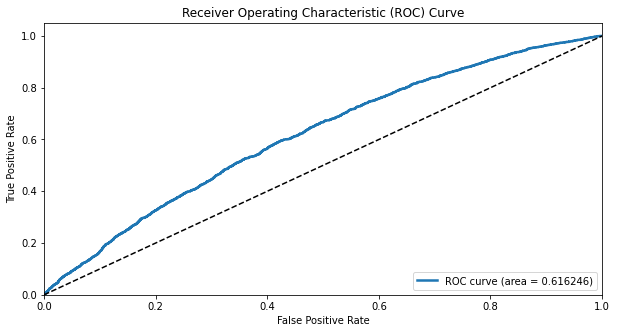

In [29]:
accuracy, precision, recall, f1_score = predict_model.get_performance(y_pred,y_test,labels=[0,1])
roc_auc = predict_model.plot_roc(cbc_randomcv,y_test,X_test)

#### 4.4 - CatBoost Classifier: Save model


In [56]:
utils.save_data_checkpoint(cbc_randomcv,'../src/models/trained_models/cbc.pickle')

Object saved successfully in ../src/models/trained_models/cbc.pickle with 0.2MB.
